In [2244]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import time

In [2]:
def preprocess():
    os.chdir('C:\\Users\\s106961\\Desktop\\Deep Learning\\Data')
    with h5py.File('train_128.h5','r') as H:
        data = np.copy(H['data'])
    with h5py.File('train_label.h5','r') as H:
        label = np.copy(H['label'])
    mu = data.mean()
    sigma = data.std()
    data = (data - mu) / sigma

    return data, label

data, label = preprocess()


In [3]:
def mini_batch(X,y, batch_size = 100):
    idx = np.array(range(0,len(y))).astype(np.int)
    np.random.shuffle(idx)
    X = X[idx[:batch_size]]
    y = y[idx[:batch_size]]
    return X, y

def weight_init(X, y, hidden_units):
    
    Weights = {}
    Bias = {}
    no_hidden = len(hidden_units)
    no_features = X.shape[1]
    for n, units in enumerate(hidden_units):
        Weights['layer_{}'.format(n+1)] = np.random.uniform(low=-np.sqrt(2. / (no_features)),high=np.sqrt(2. / (no_features)),size=(no_features, units))
        Bias['layer_{}'.format(n+1)] = np.random.uniform(low=-np.sqrt(2. / (no_features)),high=np.sqrt(2. / (no_features)),size=(units))
        no_features = units
    
    labels = len(np.unique(y))
    Weights['layer_{}'.format(no_hidden+1)] = np.random.uniform(low=-np.sqrt(2. / (no_features)), high=np.sqrt(2. / (no_features)),size=(no_features, labels))
    Bias['layer_{}'.format(no_hidden+1)] = np.random.uniform(low=-np.sqrt(2. / (no_features)),high=np.sqrt(2. / (no_features)),size=(labels))
    
    return Weights, Bias 



In [4]:
def sigmoid(inp):
    return (1/(1 + np.exp(-inp)))

def tanh(inp):
    return (np.exp(inp) - np.exp(-inp))/(np.exp(inp) + np.exp(-inp))

def relu(inp):
    return np.maximum(inp,0)

def softmax(inp):
    #op_exp = np.exp(inp)
    #return op_exp/op_exp.sum(axis = 1)[:,None]
    
    #the above code causes overflow. The below one is normalised.
    inp_max = inp.max()
    inp_norm = inp - inp_max
    return np.exp(inp_norm) / np.sum(np.exp(inp_norm), axis=1) [:,None]

def leaky_relu(inp):
    return np.maximum(inp,0.1*inp)  
   
activation_fn = {'sigmoid': sigmoid, 'tanh': tanh, 'relu': relu, 'leaky_relu': leaky_relu}

def gradient_sigmoid(inp):
    return sigmoid(inp) * (1 - sigmoid(inp))

def gradient_tanh(inp):
    return (1 -tanh(inp)) * (1 + tanh(inp))

def gradient_relu(inp):
    inp[inp>0] = 1
    inp[inp<0] = 0
    return inp

def gradient_leaky_relu(inp):
    inp[inp<0] = 0.1
    inp[inp>=0] = 1
    return inp
    
gradient_fn = {'sigmoid': gradient_sigmoid, 'tanh': gradient_tanh, 'relu': gradient_relu, 'leaky_relu':gradient_leaky_relu}

def output_label_hot_encode_old(inp):
    inp = inp.astype(int)
    classes = np.unique(inp)
    no_classes = classes.shape[0]
    no_dim = inp.shape[0]
    zero_arr = np.zeros((no_dim, no_classes))
    zero_arr[np.arange(no_dim), inp] = 1.0
    return zero_arr

def output_label_hot_encode(inp,batch_size,no_label):
    one_hot_array = np.zeros((batch_size,no_label))
    one_hot_array[np.arange(batch_size),inp] = 1
    return one_hot_array

def cross_entropy_error(y_act, y_hat):
    return np.sum(np.multiply(y_act, np.log(y_hat)) * -1)

def accuracy(y_hat, y_act):
    return round((np.sum((y_hat.argmax(axis=1) == y_act.argmax(axis=1)))/y_act.shape[0] * 100),2)

def predict(data, label, Weights, Bias, no_hidden = 2, activation = 'relu'):
    layers, y_hat = forward_propagation(data, label, Weights, Bias, no_hidden, activation)
    y_act = output_label_hot_encode(label, data.shape[0], no_label = 10)
    return y_hat, y_act

In [5]:
def forward_propagation(X, y, Weights, Bias, no_hidden, activation):
    
    layers = {}
    layers['layer_{}'.format(0)] = X #input layer

    for l in range(no_hidden):
        layers['layer_wx_{}'.format(l+1)] = np.matmul(layers['layer_{}'.format(l)], Weights['layer_{}'.format(l+1)]) + Bias['layer_{}'.format(l+1)]
        layers['layer_{}'.format(l+1)] = activation_fn[activation](layers['layer_wx_{}'.format(l+1)])
        
    layers['layer_wx_{}'.format(no_hidden+1)] = np.matmul(layers['layer_{}'.format(no_hidden)], Weights['layer_{}'.format(no_hidden+1)])
    layers['layer_{}'.format(no_hidden+1)] = softmax(layers['layer_wx_{}'.format(no_hidden+1)])
    
    y_hat = layers['layer_{}'.format(no_hidden+1)]
        
    return (layers, y_hat)

In [6]:
def backward_propagation(layers, y_act, y_hat, Weights, Bias, no_hidden, activation):
    
    gradients = {}
    dim = y_act.shape[0]
    
    gradients['dL/dA_layer_{}'.format(no_hidden+1)]  = ((y_act - y_hat) * -1)/dim
    
    for i in range(no_hidden,-1,-1):
        
        gradients['dL/dW_layer{}'.format(i+1)] = np.zeros(Weights['layer_{}'.format(i+1)].shape)
        for j in range(Weights['layer_{}'.format(i+1)].shape[0]):
            for k in range(Weights['layer_{}'.format(i+1)].shape[1]):
                gradients['dL/dW_layer{}'.format(i+1)][j][k] = np.sum((np.multiply(gradients['dL/dA_layer_{}'.format(i+1)][:,k], layers['layer_{}'.format(i)][:,j])))
                
        gradients['dL/dB_layer{}'.format(i+1)] = np.sum(gradients['dL/dA_layer_{}'.format(i+1)],axis=0)
        if i != 0:
            gradients['dL/dH_layer{}'.format(i)] = np.matmul(gradients['dL/dA_layer_{}'.format(i+1)],np.transpose(Weights['layer_{}'.format(i+1)]))
            gradients['dL/dA_layer_{}'.format(i)] = gradient_fn[activation](layers['layer_wx_{}'.format(i)]) * gradients['dL/dH_layer{}'.format(i)]
    
    return gradients

In [37]:
def gradient_descent(gradients, Weights, Bias, learning_rate,no_hidden):
    for i in range(no_hidden+1,0,-1):
        Weights['layer_{}'.format(i)] = Weights['layer_{}'.format(i)] - (learning_rate * gradients['dL/dW_layer{}'.format(i)])
        Bias['layer_{}'.format(i)] = Bias['layer_{}'.format(i)] - (learning_rate * gradients['dL/dB_layer{}'.format(i)])
        
    return Weights, Bias

def momentum_gradient_descent(gradients, Weights, Bias, learning_rate,no_hidden, rho, prev_gradients):
    momentum_gradient = {}
    for i in range(no_hidden+1,0,-1):
        momentum_gradient['dL/dW_layer{}'.format(i)] = (rho * prev_gradients['dL/dW_layer{}'.format(i)]) + (learning_rate * gradients['dL/dW_layer{}'.format(i)])
        momentum_gradient['dL/dB_layer{}'.format(i)] = (rho * prev_gradients['dL/dB_layer{}'.format(i)]) + (learning_rate * gradients['dL/dB_layer{}'.format(i)])
        Weights['layer_{}'.format(i)] = Weights['layer_{}'.format(i)] - momentum_gradient['dL/dW_layer{}'.format(i)]
        Bias['layer_{}'.format(i)] = Bias['layer_{}'.format(i)] - momentum_gradient['dL/dB_layer{}'.format(i)]
        
    return Weights, Bias, momentum_gradient

In [65]:
def train(data, label, hidden_units, Weights, Bias, activation = 'sigmoid', descent_method = 'momentum_gradient_descent', 
          epochs = 10000, learning_rate = 0.01,batch_size = 100):
    
    start = time.time()    
    error = []   
    no_hidden = len(hidden_units)
    no_label = len(np.unique(label))
    rho = 0.9

    for i in range(epochs):
        X, y = mini_batch(data,label,batch_size)
        y_act = output_label_hot_encode(y, batch_size, no_label)
        layers, y_hat = forward_propagation(X, y, Weights, Bias, no_hidden, activation)
        gradients = backward_propagation(layers, y_act, y_hat, Weights, Bias, no_hidden, activation)
        
        if descent_method == 'gradient_descent':
            Weights, Bias = gradient_descent(gradients, Weights, Bias, learning_rate, no_hidden)
        elif descent_method == 'momentum_gradient_descent':
            if i == 0:
                prev_gradients = {layer:gradients[layer] * 0 for layer in gradients}
            Weights, Bias, prev_gradients = momentum_gradient_descent(gradients, Weights, Bias, learning_rate, no_hidden,
                                                                      rho, prev_gradients)
            
        ce_error = cross_entropy_error(y_act, y_hat)
        
        if i%100 == 0: error.append(ce_error)
        if i%1000 == 0: 
            pred_y_hat, pred_y_act = predict(data, label, Weights, Bias, no_hidden, activation = 'relu')
            print('Epoch:' + str(i) + ' Error:' + str(round(ce_error,2)) + ' Accuracy:' + str(accuracy(pred_y_hat, pred_y_act)))
        
    end = time.time()
    print('Training time: ' + str(round((end - start)/60)) + ' mins')
    return error, y_act, y_hat, Weights, i

In [67]:
hidden_units = [4,4,3]
no_hidden = len(hidden_units)
Weights, Bias = weight_init(data, label, hidden_units)

Epoch:0 Error:274.19 Accuracy:10.0
Epoch:1000 Error:173.39 Accuracy:28.26
Epoch:2000 Error:171.39 Accuracy:43.96
Epoch:3000 Error:146.32 Accuracy:46.25
Epoch:4000 Error:153.04 Accuracy:47.04
Epoch:5000 Error:164.26 Accuracy:46.84
Epoch:6000 Error:154.59 Accuracy:46.93
Epoch:7000 Error:133.19 Accuracy:46.54
Epoch:8000 Error:145.07 Accuracy:47.15
Epoch:9000 Error:147.89 Accuracy:47.47
Epoch:10000 Error:141.09 Accuracy:47.4
Epoch:11000 Error:165.66 Accuracy:47.4
Epoch:12000 Error:145.53 Accuracy:47.3
Epoch:13000 Error:157.12 Accuracy:47.12
Epoch:14000 Error:124.66 Accuracy:47.27
Epoch:15000 Error:83.48 Accuracy:60.32
Epoch:16000 Error:88.77 Accuracy:66.73
Epoch:17000 Error:71.41 Accuracy:74.3
Epoch:18000 Error:60.72 Accuracy:75.66
Epoch:19000 Error:72.45 Accuracy:77.43
Training time: 5 mins
Accuracy 77.79


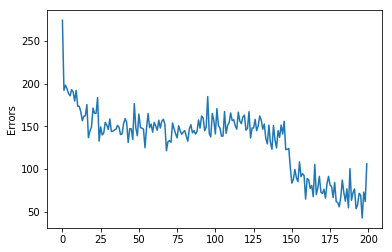

In [68]:
error, y_act, y_hat, Weight_new, iters = train(data, label, hidden_units, Weights, Bias, activation = 'relu',
                                               descent_method = 'momentum_gradient_descent', epochs = 20000, 
                                               learning_rate = 0.01,batch_size = 100)
pred_y_hat, pred_y_act = predict(data, label, Weights, Bias, no_hidden, activation = 'relu')
print('Accuracy ' + str(accuracy(pred_y_hat, pred_y_act)))
plt.plot(error)
plt.ylabel('Errors')
plt.show()

In [71]:
pred_y_hat, pred_y_act = predict(data, label, Weights, Bias, no_hidden, activation = 'relu')
print('Accuracy ' + str(accuracy(pred_y_hat, pred_y_act)))

Accuracy 77.79
